# Demo: MNIST

This notebook demonstrates the $k$-nearest minimum spanning tree ($k$-MST) behaves on MNIST [[1]](https://ieeexplore.ieee.org/document/726791/), a handwritten digit dataset containing clusters. We measure the methods' compute times and compare their model sizes in relation to the structure they capture.

In [1]:
import numpy as np
import pandas as pd

from scipy.sparse import save_npz, load_npz
from sklearn.datasets import fetch_openml

import warnings
from numba import NumbaPendingDeprecationWarning
# UMAP warns when spectral initialisation fails or points are not connected
warnings.filterwarnings("ignore", category=UserWarning)
# sklearn data loading raises a future warning
warnings.filterwarnings("ignore", category=FutureWarning)
# UMAP / PYNNDescent not yet updated for recent numba versions
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)

from umap import UMAP
from multi_mst import KMST, KMSTDescent

We use a UMAP's cross-entropy optimisated layout [[2]](http://arxiv.org/abs/1802.03426) in a two-stage process that increases repulsion in the second stage to avoid split classes. By running with a low repulsion first, connected points can get close together easily. Then, a higher repulsion run increases separation between classes.

In [8]:
import umap.distances as dist
from umap.umap_ import find_ab_params, simplicial_set_embedding
from sklearn.utils import check_random_state


def embed_graph(
    data,
    graph,
    repulsion_strength=np.float32(1),
    negative_sample_rate=np.int32(5),
    spread=np.float32(1.0),
    min_dist=np.float32(0.1),
):
    a, b = find_ab_params(spread, min_dist)
    input_distance_func = dist.named_distances["euclidean"]
    output_metric = "euclidean"
    output_metric_kwds = {}
    output_distance_func = dist.named_distances_with_gradients[output_metric]
    
    embedding, aus = simplicial_set_embedding(
        data,
        graph,
        np.int32(2),
        np.float32(1.0),
        a,
        b,
        np.float32(0.1),
        negative_sample_rate,
        np.int32(200),
        "spectral",
        check_random_state(None),
        input_distance_func,
        {},
        False,
        {},
        False,
        output_distance_func,
        output_metric_kwds,
        output_metric in ("euclidean", "l2"),
        True,
        False,
        tqdm_kwds=None,
    )
    embedding, aus = simplicial_set_embedding(
        data,
        graph,
        np.int32(2),
        np.float32(1.0),
        a,
        b,
        np.float32(1.0),
        negative_sample_rate,
        np.int32(300),
        embedding,
        check_random_state(None),
        input_distance_func,
        {},
        False,
        {},
        False,
        output_distance_func,
        output_metric_kwds,
        output_metric in ("euclidean", "l2"),
        True,
        False,
        tqdm_kwds=None,
    )

    
    return embedding

We use datashader [[3]](https://datashader.org/getting_started/Introduction.html) to draw a large number of nodes or edges onto a matplotlib axis as an image. This code was inspired by UMAP's plotting functions and the HoloViz code-base.

In [28]:
import numba as nb
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import directly_connect_edges

import matplotlib.pyplot as plt
from matplotlib.colors import to_hex


def get_data_extent(df, x_pad=0.05, y_pad=0.05):
    """Returns extreme coordinate value given a suffix."""
    x = f"x"
    y = f"y"
    min_x = np.nanmin(df[x])
    max_x = np.nanmax(df[x])
    min_y = np.nanmin(df[y])
    max_y = np.nanmax(df[y])

    return (
        min_x - x_pad * (max_x - min_x),
        max_x + x_pad * (max_x - min_x),
        min_y - y_pad * (max_y - min_y),
        max_y + y_pad * (max_y - min_y),
    )


def get_ax_size(fig, ax):
    """Determines matplotlib axis resolution."""
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    return int(np.round(bbox.width * fig.dpi)), int(np.round(bbox.height * fig.dpi))


@nb.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _red(x):
    """Extracts red values from datashader image."""
    return (x & 0xFF0000) >> 16


@nb.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _green(x):
    """Extracts green values from datashader image."""
    return (x & 0x00FF00) >> 8


@nb.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _blue(x):
    """Extracts blue values from datashader image."""
    return x & 0x0000FF


def shade_mpl(df, agg, extent, **kwargs):
    """Datashades a given matplotlib axes."""
    domain = get_ax_size(plt.gcf(), plt.gca())
    result = _shade_mpl(df, agg, extent, domain, **kwargs)
    img_rev = result.data[::-1]
    stack = np.dstack([_blue(img_rev), _green(img_rev), _red(img_rev)])
    alpha = np.where((stack == 255).all(axis=2), 0, 255)
    plt.gca().imshow(np.dstack((stack, alpha)), extent=extent)
    plt.gca().set_aspect("auto")


def _shade_mpl(
    df, agg, extent, domain,
    kind='points', 
    operation=None,
    px=0,
    how='add',
    cmap=None,
    color_key=None,
    clim=None,
    cnorm='eq_hist',
    min_alpha=40,
    color_baseline=None,
    rescale_discrete_levels=False,
    background='white',
):
    """Datashades data to a given size image.""" 
    kdims = ['x', 'y']
    if color_key is None and cmap is None:
        cmap = plt.get_cmap('Blues' if kind == 'points' else 'gray_r')
    
    canvas = ds.Canvas(
        plot_width=domain[0],
        plot_height=domain[1],
        x_range=(extent[0], extent[1]),
        y_range=(extent[2], extent[3]),
    )
    rasterizer = canvas.line if kind == 'lines' else canvas.points
    raster = rasterizer(df, kdims[0], kdims[1], agg=agg)
    if operation is not None:
        raster = operation(raster)
    if px > 0:
        raster = tf.spread(raster, px=px, how=how)
    image = tf.shade(
        raster,
        color_key=color_key,
        cmap=cmap,
        span=clim,
        how=cnorm,
        alpha=255,
        min_alpha=min_alpha,
        color_baseline=color_baseline,
        rescale_discrete_levels=rescale_discrete_levels,
    )
    if background is not None:
        image = tf.set_background(image, background)
    return image   

To interpret the embeddings, we draw all edges in the models and overlay a sample of the digits handwritten digits as scatterplot markers. This way, we can see the variations within each digit and interpret how digits are similar. 

In [1]:
from matplotlib.colors import to_rgb
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import MaxAbsScaler

def frame_off():
    """Disables frames and ticks."""
    plt.xticks([])
    plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_visible(False)


def draw_digits(graph, alg='kmst'):
    s = 1.7438 # width and height for figure in the paper
    graph = graph.tocoo()

    # Scale to [-1, 1] to make OffsetImage work...
    X2 = MaxAbsScaler().fit_transform(embed_graph(df, graph))
    X_emb = pd.DataFrame(X2, columns=['x', 'y'])
    X_emb['class'] = target.to_numpy()
    X_emb['class'] = X_emb['class'].astype('category')

    extent = get_data_extent(X_emb, x_pad=0.01, y_pad=0.01)
    show_sample = np.concatenate(
        X_emb.reset_index().groupby('class').index.apply(
            lambda x: np.random.choice(x, 45, replace=False)
        ).to_numpy()
    )

    lines = pd.DataFrame(
        np.vstack([graph.row, graph.col, graph.data]).T,
        columns=["source", "target", "weight"],
    )
    lines["source"] = lines.source.astype(np.int32)
    lines["target"] = lines.target.astype(np.int32)
    lines = directly_connect_edges(X_emb, lines, weight="weight")

    fig = plt.figure(figsize=(s, s), dpi=300)
    frame_off()
    plt.subplots_adjust(0, 0, 1, 1)
    ax = plt.gca()
    shade_mpl(
        lines,
        ds.sum("weight"),
        extent,
        # px=1,
        cnorm='linear',
        kind="lines",
        # operation=lambda x: x.where(x > 0.5),
        min_alpha=255
    )
    for i in show_sample:
        rgb = to_rgb(f'C{X_emb["class"][i]}')
        arr = df.iloc[i, :].to_numpy().reshape(28, 28) / 255
        arr = np.stack((arr * rgb[0], arr * rgb[1], arr * rgb[2], arr > 0), axis=2)
        im = OffsetImage(arr, zoom=0.145)
        ab = AnnotationBbox(im, X2[i,:], frameon=False)
        ax.add_artist(ab)
    
    plt.savefig(f'./images/mnist_digits_{alg}.png', dpi=300, pad_inches=0)
    plt.show()

Load the data using sklearn:

In [3]:
df, target = fetch_openml("mnist_784", version=1, return_X_y=True)
df.shape

(70000, 784)

## $k$-MST

The $k$-MST sufficiently connects classes at $k=2$. The distance threshold $\epsilon$ can be used to sparsify the result. $\epsilon=1.1$ appears to work nicely.

- $\epsilon = inf$ creates 236.440 edges
- $\epsilon = 1.2$ creates 221.892 edges
- $\epsilon = 1.1$ creates 201.032 edges
- $\epsilon = 1.05$ creates 179.848  edges

In [6]:
epsilon = 1.1
p = KMST(num_neighbors=2, epsilon=epsilon, transform_mode='graph').fit(df)
save_npz(f'./data/generated/mnist/demo_kmst_{epsilon}.npz', p.graph_.tocoo())
p.graph_.nnz

201032

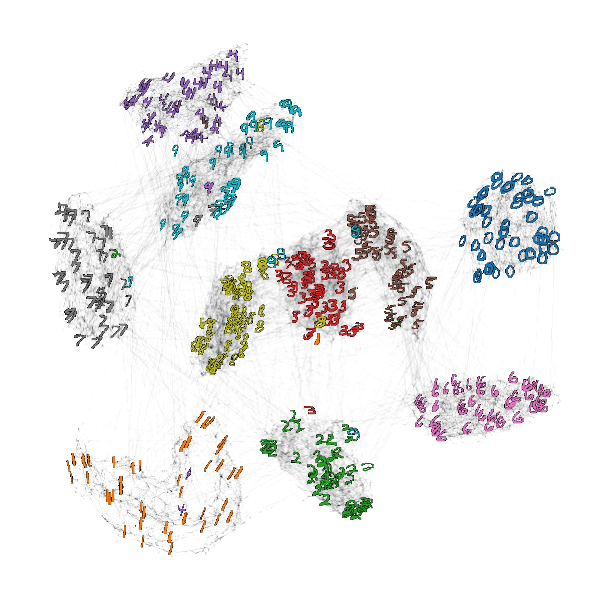

In [58]:
draw_digits(p.graph_, alg='kmst')

#### Compute times

The KDTree based nearest neighbour lookup does not work well on this dataset. Generally KDTrees are advised when $n >> 2^d$, where $n$ is the number of data points and $d$ the number of features. MNIST does not satisfy that property, leaving the KDTree about as expensite to compute as a brute-force neighbour lookup.

In [8]:
%%timeit
p = KMST(num_neighbors=2, epsilon=epsilon, umap_kwargs=dict(transform_mode='graph')).fit(df)

10min 47s ± 29.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is where the approximate $k$-MST algorithm helps:

In [7]:
%%timeit
p = KMSTDescent(num_neighbors=2, epsilon=epsilon, umap_kwargs=dict(transform_mode='graph')).fit(df)

8.89 s ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## UMAP (k=5)

The lowest fully connected $k=5$ creates a network with 427046 edges. This model captures more in-cluster and more cross-cluster connectivity.

In [9]:
p_umap = UMAP(n_neighbors=5, transform_mode='graph').fit(df)
save_npz('./data/generated/mnist/demo_umap.npz', p_umap.graph_.tocoo())
p_umap.graph_.nnz

427118

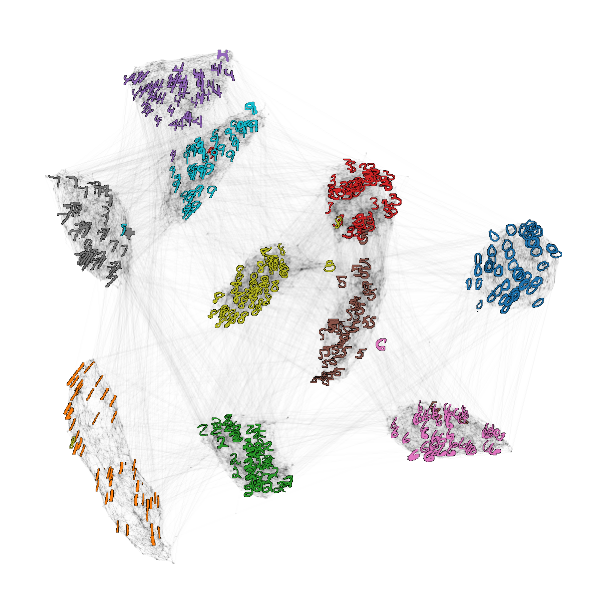

In [85]:
draw_digits(p_umap.graph_, alg='umap')

#### Compute time

UMAP uses NNDescent [[4]](https://dl.acm.org/doi/10.1145/1963405.1963487) to find approximate nearest neighbours. This iterative gradient-descent-based process is quick!

In [11]:
%%timeit
p_umap = UMAP(n_neighbors=5, transform_mode='graph').fit(df)

1.91 s ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
